# 目的
- エンゼルがある回数で出現した確率、今後エンゼルが出現する回数の予測をする

In [1]:
import sys, os
import sqlite3
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

from datetime import datetime as dt

import scipy.stats as stats


# データの取得
- データはDB（sqlite）に保存されている
    - テーブル定義は、ブログに載っている通り

In [2]:
def get_data(db_file='../data/choco-ball.db', table_name='measurement', filter_str=None):
    """
    dbファイルから計測データを取得する
    
    TODO:
        エラー処理を入れる
    """
    con = sqlite3.connect(db_file)
    sql = 'SELECT '
    sql += 'measure_date,best_before,prd_number,weight,box_weight,ball_number,factory,shop,angel,campaign,taste '
    sql += ', (weight - box_weight), (weight - box_weight)/ball_number '
    sql += 'FROM ' + table_name + ' '
    if filter_str is not None:
        sql += 'WHERE ' + filter_str
    sql += ';'
    sql_result = con.execute(sql)
    res = sql_result.fetchall()
    con.close()
    data = pd.DataFrame(res, columns=['measure_date','best_before','prd_number','weight','box_weight','ball_number','factory','shop','angel','campaign','taste','net_weight','mean_weight'])
    print 'Shape of MeasurementData(record_num, n_columns) : {}'.format(data.shape)
    return data

# 幾何分布

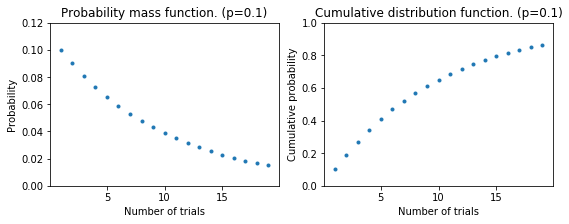

In [3]:
p = 0.1
ns = np.arange(1,20,1)

fig = plt.figure(figsize=(9,3))
ax1 = fig.add_subplot(1,2,1)
ax1.plot(ns, stats.geom.pmf(ns, p), '.')
ax1.set_title("Probability mass function. (p={})".format(p))
ax1.set_xlabel("Number of trials")
ax1.set_ylabel("Probability")
ax1.set_ylim([0, max(stats.geom.pmf(ns, p))*1.2])

ax2 = fig.add_subplot(1,2,2)
ax2.plot(ns, stats.geom.cdf(ns, p), '.')
ax2.set_title("Cumulative distribution function. (p={})".format(p))
ax2.set_xlabel("Number of trials")
ax2.set_ylabel("Cumulative probability")
ax2.set_ylim([0, 1.0])

fig.savefig('geom_dist.png')

# 試行回数の推定

In [4]:
def getAngelTryNumber(n, p=0.001, minN=1, maxN=1000, fname=None):
    cdf = stats.geom.cdf(np.arange(minN, maxN), p=p)
    
    plt.figure()
    plt.plot(cdf, color="blue", label="CDF")
    plt.xlabel("number of sample")
    plt.title("Cumulative distribution function. p={}".format(p))
    plt.vlines(x=n, ymin=0, ymax=1.0, color="red", label="Number of Trial")
    plt.legend()
    if fname is not None:
        plt.savefig(fname)
    
    pmf = stats.geom.pmf(n, p=p)
    cdf = stats.geom.cdf(n, p=p)
    print("p={}, n={} -> pmf={:.4f}, cdf={:.4}".format(p, n, pmf, cdf))
    return {"p":p, "n":n, "pmf":pmf, "cdf":cdf}

## ベイズ推定を利用したエンゼルの出現確率
- (第29回計測)[http://chocolate-ball.hatenablog.com/entry/2018/01/22/202355:embed:cite]を参照
- 予測確率は以下の通り
    - 下限:0.07%
    - 上限:3.77%
    - 期待値:1.29%

p=0.0129, n=78 -> pmf=0.0047, cdf=0.6368
p=0.0007, n=78 -> pmf=0.0007, cdf=0.05315
p=0.0377, n=78 -> pmf=0.0020, cdf=0.9501


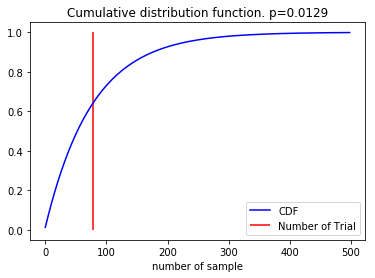

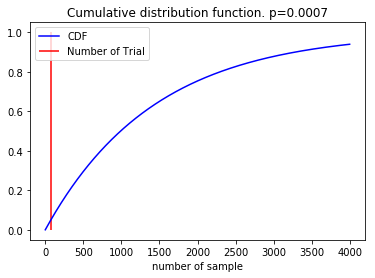

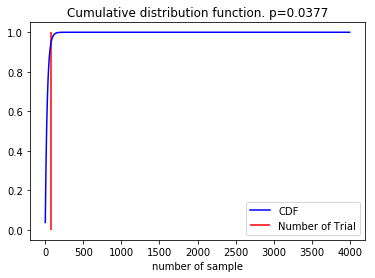

In [5]:
# 出現確率
p = 0.0129
# 試行回数
n = 78

ret = getAngelTryNumber(n=n, p=p, minN=1, maxN=500, fname="cdf_bayese.png")
ret = getAngelTryNumber(n=n, p=0.0007, minN=1, maxN=4000)
ret = getAngelTryNumber(n=n, p=0.0377, minN=1, maxN=4000)

## 様々な人の集計結果
- 以下の3記事を参考にさせていただきました
    - [【1,000箱目】森永チョコボール 金・銀のエンゼルが出る確率を出す(鳥取の社長日記)](http://blog.livedoor.jp/remsy/archives/51931218.html)
    - [ヒカルが検証！　チョコボールで金のエンゼルが当たる確率は？（YouTuberのネタ宝庫　アイデア＆アイテム集結）](http://www.youtuber-item.com/entry/2017/01/19/212219)
    - [９１５分の１って！「月曜から夜ふかし」が金のエンゼルが出る確率を検証した結果](http://mystock-abc.xyz/?p=476)

p=0.0028, n=78 -> pmf=0.0023, cdf=0.1964


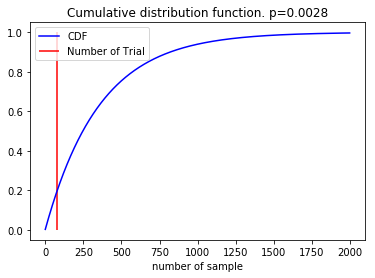

In [6]:
# 出現確率
p = 0.0014*2 # 現在はエンゼル出現率が2倍
# 試行回数
n = 78

ret = getAngelTryNumber(n=n, p=p, minN=1, maxN=2000, fname="cdf_likelihood.png")

## N個買ったら当たる確率

p=0.0028, n=357 -> pmf=0.0010, cdf=0.6325
p=0.0028, n=250 -> pmf=0.0014, cdf=0.5039


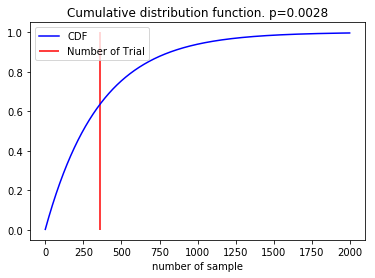

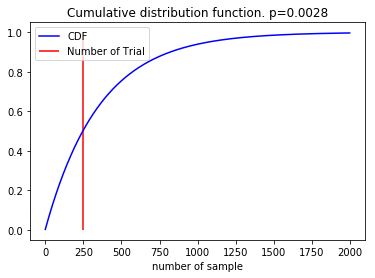

In [7]:
# 出現確率(様々な人の集計結果を利用)
p = 0.0014*2

ret = getAngelTryNumber(n=357, p=p, minN=1, maxN=2000)
ret = getAngelTryNumber(n=250, p=p, minN=1, maxN=2000)